In [97]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        self.xmin = xmin
        self.xmax = xmax 
        self.num_points = num_points
        self.resolution = (xmax-xmin)/num_points
        self.x_data  = np.linspace(xmin, xmax, num_points)
        self.y_true = np.sin(self.x_data)
    
    #To compare data which we dont have 
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    def nxt_batch(self, batch_size, steps, return_batch_ts = False):
        
        #Get a random starting point to the batch size 
        rand_start = np.random.rand(batch_size, 1)
        
        #Make the point fall on the time series
        ts_start  = rand_start * (self.xmax - self.xmin - (steps * self.resolution))
        
        #Create a batch of data
        batch_ts = ts_start + np.arange(0.0, steps + 1) * self.resolution
        
        y_batch = np.sin(batch_ts)
        
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1), batch_ts
        else:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1)
        

In [99]:
ts_data = TimeSeriesData(250, 0, 10)

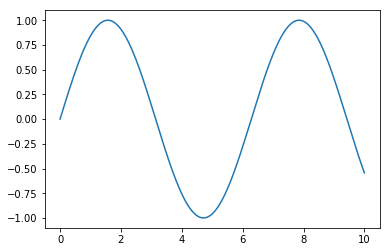

In [100]:
plt.plot(ts_data.x_data, ts_data.y_true)

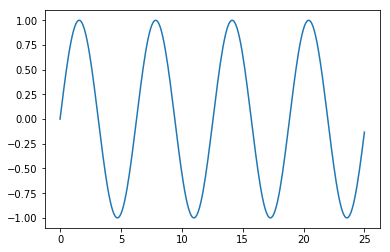

In [101]:
ts_data = TimeSeriesData(250, 0, 25)
plt.plot(ts_data.x_data, ts_data.y_true)

In [102]:
num_steps = 30
y1, y2, ts = ts_data.nxt_batch(1, num_steps,True)

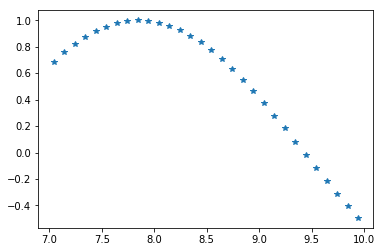

In [103]:
plt.plot(ts.flatten()[1:,],y2.flatten(), '*' )

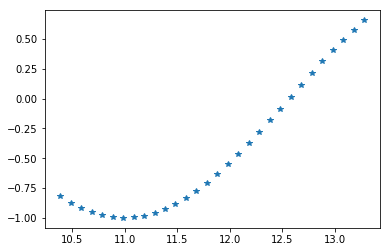

In [104]:
num_steps = 30
y1, y2, ts = ts_data.nxt_batch(1, num_steps,True)
plt.plot(ts.flatten()[1:,],y2.flatten(), '*' )

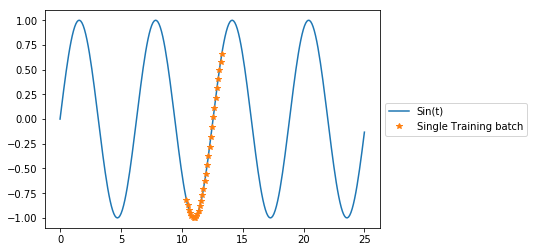

In [105]:
plt.plot(ts_data.x_data, ts_data.y_true, label = 'Sin(t)')
plt.plot(ts.flatten()[1:,], y2.flatten(), '*', label='Single Training batch')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.tight_layout()


In [106]:
train_data = np.linspace(5, 5 + ts_data.resolution * (num_steps + 1), num_steps + 1)

In [107]:
train_data[:-1]


array([ 5.        ,  5.10333333,  5.20666667,  5.31      ,  5.41333333,
        5.51666667,  5.62      ,  5.72333333,  5.82666667,  5.93      ,
        6.03333333,  6.13666667,  6.24      ,  6.34333333,  6.44666667,
        6.55      ,  6.65333333,  6.75666667,  6.86      ,  6.96333333,
        7.06666667,  7.17      ,  7.27333333,  7.37666667,  7.48      ,
        7.58333333,  7.68666667,  7.79      ,  7.89333333,  7.99666667])

In [108]:
train_data

array([ 5.        ,  5.10333333,  5.20666667,  5.31      ,  5.41333333,
        5.51666667,  5.62      ,  5.72333333,  5.82666667,  5.93      ,
        6.03333333,  6.13666667,  6.24      ,  6.34333333,  6.44666667,
        6.55      ,  6.65333333,  6.75666667,  6.86      ,  6.96333333,
        7.06666667,  7.17      ,  7.27333333,  7.37666667,  7.48      ,
        7.58333333,  7.68666667,  7.79      ,  7.89333333,  7.99666667,
        8.1       ])

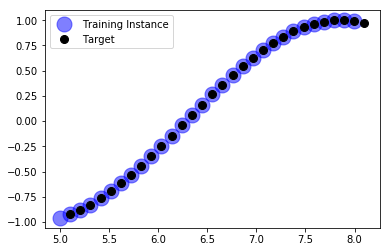

In [109]:
plt.plot(train_data[:-1], ts_data.ret_true(train_data[:-1]),'bo', markersize = 15, alpha = 0.5, label = 'Training Instance')

plt.plot(train_data[1:], ts_data.ret_true(train_data[1:]), 'ko', markersize = 8, label = 'Target')

plt.legend()

In [110]:
tf.reset_default_graph()

In [111]:
num_ip = 1

In [112]:
num_neurons = 100

In [113]:
num_op = 1

In [114]:
learning_rate = 0.001 

In [115]:
num_train_iterations = 2000

In [116]:
batch_size = 1

In [117]:
# Place holders 
##NONE is the batch size for that dimension 

In [118]:
X = tf.placeholder(tf.float32,[None, num_steps, num_ip])

In [119]:
y = tf.placeholder(tf.float32, [None, num_steps, num_op])

In [120]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)
##Since we are using 100 neurons the RNN model will spit out 100 outputs, as in 
#our code sample we will be needing only 
#one output, Hence we will be using a output wrapper fucntion 
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_op)

In [121]:
##Dynamic RNN  = spits states & outputs of the cell 
#it unrolls the inputs -> which means that it uses while loop to 
#run over the cell appropriate num of times 
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [122]:
# Loss Function - we will be using MSE for loss function 
loss = tf.reduce_mean(tf.square(outputs - y))

In [123]:
# for optimizer -> User AdamOptimizer 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [124]:
train = optimizer.minimize(loss)

In [125]:
#initialize global variables 
init = tf.global_variables_initializer()

In [126]:
gpu_opt = tf.GPUOptions(per_process_gpu_memory_fraction = 0.85)

In [127]:
#Save the model inorder to be used again 
saver = tf.train.Saver()

In [128]:

with tf.Session(config = tf.ConfigProto(gpu_options = gpu_opt)) as sess:
    sess.run(init)
    
    for iterations in range(num_train_iterations):
        
        X_batch, y_batch = ts_data.nxt_batch(batch_size, num_steps)
        
        sess.run(train, feed_dict={X:X_batch, y:y_batch})
        
        #Calculate accuracy for every 100 steps & report
        if iterations % 100 == 0:
            mse = loss.eval(feed_dict={X:X_batch, y:y_batch})
            print(iterations, "\tMSE", mse)
        
    saver.save(sess, "./rnn_saver_model_codealong")

0 	MSE 0.508911
100 	MSE 0.0303273
200 	MSE 0.0366753
300 	MSE 0.00724018
400 	MSE 0.00649662
500 	MSE 0.00576021
600 	MSE 0.0022252
700 	MSE 0.00865878
800 	MSE 0.00246323
900 	MSE 0.0044309
1000 	MSE 0.00121344
1100 	MSE 0.00281639
1200 	MSE 0.000915068
1300 	MSE 0.000387883
1400 	MSE 0.00095396
1500 	MSE 0.000891045
1600 	MSE 0.000915094
1700 	MSE 0.000752428
1800 	MSE 0.000519998
1900 	MSE 0.000458904


In [129]:
#Done with training the model
#Now how to predic the model into the future???????

#For that 
# create another session 
with tf.Session() as sess:
    saver.restore(sess, "./rnn_saver_model_codealong")
    
    X_new = np.sin(np.array(train_data[:-1].reshape(-1,num_steps,num_ip)))
    y_pred = sess.run(outputs, feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from ./rnn_saver_model_codealong


INFO:tensorflow:Restoring parameters from ./rnn_saver_model_codealong


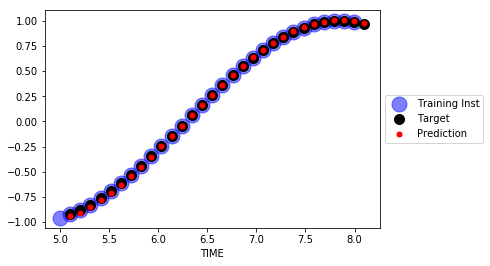

In [130]:
#Training data points
plt.plot(train_data[:-1], np.sin(train_data[:-1]), "bo", markersize = 15, alpha = 0.5, label = "Training Inst")

#Target data points of the training instance
plt.plot(train_data[1:], np.sin(train_data[1:]), "ko", markersize = 10, label = "Target")

#Models Prediction 
plt.plot(train_data[1:], y_pred[0,:,0], 'r.', markersize = 10, label="Prediction")

plt.xlabel("TIME")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



In [131]:
y_pred[0,:,0]

array([-0.93660492, -0.91383064, -0.84701872, -0.77921635, -0.71043432,
       -0.63276941, -0.54493999, -0.45033255, -0.35127306, -0.2495759 ,
       -0.14626302, -0.0422396 ,  0.06160549,  0.16445395,  0.26593915,
        0.36508992,  0.46108037,  0.5513761 ,  0.63550377,  0.71278435,
        0.78193188,  0.84259474,  0.89429861,  0.93652499,  0.96882051,
        0.99097395,  1.00277591,  1.00407314,  0.99481928,  0.97509283], dtype=float32)

### Generating a new set of sequence 

In [133]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_saver_model_codealong")
    
    #Seeding only 0s for the number of time steps
    
    zero_seed = [0.0 for i in range(num_steps)]
    
    for iterations in range(len(ts_data.x_data) - num_steps):
        X_batch = np.array(zero_seed[-num_steps:]).reshape(1,num_steps,1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        zero_seed.append(y_pred[0,-1,0])
        

INFO:tensorflow:Restoring parameters from ./rnn_saver_model_codealong


INFO:tensorflow:Restoring parameters from ./rnn_saver_model_codealong


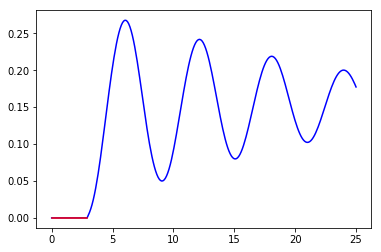

In [137]:
plt.plot(ts_data.x_data, zero_seed, 'b-')
plt.plot(ts_data.x_data[:num_steps], zero_seed[:num_steps], 'r')

#### In the above sequence since we are feeding the values starting from 0, 
#### it generates a sinusoidal wave almost but not exactly

In [138]:
with tf.Session() as sess:
    saver.restore(sess, "./rnn_saver_model_codealong")
    
    #Seeding only 0s for the number of time steps
    
    training_inst = list(ts_data.y_true[:30])
    
    for iterations in range(len(training_inst) - num_steps):
        X_batch = np.array(training_inst[-num_steps:]).reshape(1,num_steps,1)
        y_pred = sess.run(outputs, feed_dict={X:X_batch})
        training_inst.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./rnn_saver_model_codealong


INFO:tensorflow:Restoring parameters from ./rnn_saver_model_codealong


In [ ]:
plt.plot(ts_data.x_data, ts_data.y_true, 'b-')
plt.plot(ts_data.x_data[:num_steps], zero_seed[:num_steps], 'r')